In [1]:
import pandas as pd
import numpy as np

In [2]:
import random
from sklearn.model_selection import train_test_split

prng = np.random.RandomState(20240322)

real_estate_data = pd.read_csv("https://raw.githubusercontent.com/divenyijanos/ceu-ml/2023/data/real_estate/real_estate.csv")

real_estate_data_raw_cols = real_estate_data.columns.to_list()

In [3]:
real_estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   414 non-null    int64  
 1   transaction_date                     414 non-null    float64
 2   house_age                            414 non-null    float64
 3   distance_to_the_nearest_MRT_station  414 non-null    float64
 4   number_of_convenience_stores         414 non-null    int64  
 5   latitude                             414 non-null    float64
 6   longitude                            414 non-null    float64
 7   house_price_of_unit_area             414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


In [4]:
real_estate_sample = real_estate_data.sample(frac=0.2, random_state=prng)
outcome = real_estate_sample["house_price_of_unit_area"]
features = real_estate_sample.drop(columns=["house_price_of_unit_area", "id", "transaction_date"])
X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size=0.3, random_state=prng)
print(f"Size of the training set: {y_train.shape[0]}, size of the test set: {y_test.shape[0]}")

Size of the training set: 58, size of the test set: 25


#### Think about an appropriate loss function you can use to evaluate your predictive models. What is the risk (from a business perspective) that you would have to take by making a wrong prediction?

As we are trying to build a webapp where potential buyers and sellers could rate their homes, it is important to focus on the accuracy of the price prediction. If we overestimate the price, houses may not be sold and no revenue are made. On the other hand, if we underestimate the price, houses may be sold faster, but we will have significant revenue loss. In both cases, we will experience revenue loss and loss in customer trust in our service. However, it is worth noting that overestimating the house price may be worse than underestimating it since we won't make any revenue at all on overestimation. In summary, since we value prediction accuracy in our business, RMSE (Root Mean Squared Error) may be the best loss function since it tells us how close our predictions are with the same unit as the true values.

#### Build a simple benchmark model and evaluate its performance on the hold-out set (using your chosen loss function).

In [5]:
from sklearn.metrics import root_mean_squared_error

# build the benchmark model using just the average as estimations
y_pred = np.mean(y_train)

summary_df = pd.DataFrame({'Model': ['Benchmark'],
                              'Train RMSE': ['{:.4f}'.format(root_mean_squared_error(y_train, np.array([y_pred] * len(y_train))))],
                              'Holdout RMSE': ['{:.4f}'.format(root_mean_squared_error(y_test, np.array([y_pred] * len(y_test))))]
                              })
summary_df

,Model,Train RMSE,Holdout RMSE
0,Benchmark,12.3012,12.7846


#### Build a simple linear regression model using a chosen feature and evaluate its performance. Would you launch your evaluator web app using this model?

In [6]:
from sklearn.linear_model import LinearRegression

# simple linear model with 1 feature (distance_to_the_nearest_MRT_station)
simple_model = LinearRegression()
simple_model.fit(X_train[['distance_to_the_nearest_MRT_station']], y_train)

model_name = 'Simple Linear Regression'

if model_name not in summary_df.Model.values:
    summary_df.loc[len(summary_df.index)] = [model_name, 
                                             '{:.4f}'.format(root_mean_squared_error(y_train, simple_model.predict(X_train[['distance_to_the_nearest_MRT_station']]))),
                                             '{:.4f}'.format(root_mean_squared_error(y_test, simple_model.predict(X_test[['distance_to_the_nearest_MRT_station']])))]
summary_df

,Model,Train RMSE,Holdout RMSE
0,Benchmark,12.3012,12.7846
1,Simple Linear Regression,8.4990,9.3673


Compared to the benchmark model, the simple linear model with only 1 predictor improves the RMSE in the training set. With the holdout set, the performance also improves compared to that of the benchmark model. We may want to launch our webapp with this simple linear model. However, it is better to make a decision after comparing it to a multivariate model.

#### Build a multivariate linear model with all the meaningful variables available. Did it improve the predictive power?

In [7]:
# multivariate model
multivariate_model = LinearRegression()
multivariate_model.fit(X_train, y_train)

model_name = 'Multivariate Linear Regression'

if model_name not in summary_df.Model.values:
    summary_df.loc[len(summary_df.index)] = [model_name, 
                                             '{:.4f}'.format(root_mean_squared_error(y_train, multivariate_model.predict(X_train))),
                                             '{:.4f}'.format(root_mean_squared_error(y_test, multivariate_model.predict(X_test)))]
summary_df

,Model,Train RMSE,Holdout RMSE
0,Benchmark,12.3012,12.7846
1,Simple Linear Regression,8.4990,9.3673
2,Multivariate Linear Regression,6.8995,9.4153


From the summary table, the multivariate linear model performs better than the simple linear model and the benchmark model. This means including more variables are meaningful to capture the variance in house price.

#### Try to make your model (even) better. Document your process and its success while taking two approaches:
1. Feature engineering - e.g. including squares and interactions or making sense of lati- tude&longitude by calculating the distance from the city center, etc.
2. Training more flexible models - e.g. random forest or gradient boosting

##### 1. Feature engineering

In [8]:
import math

city_center_coords = (25.0114, 121.4618)
def get_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Difference in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
    # Earth radius in meters
    R = 6_371_000.0
    
    # Total distance in meters
    distance = R * c
    
    return distance

# feature engineering
real_estate_data['distance_to_city_center'] = real_estate_data[['latitude', 'longitude']].apply(lambda x: get_distance(city_center_coords[0], city_center_coords[1], x['latitude'], x['longitude']), axis=1)

real_estate_data['transaction_year'] = np.floor(real_estate_data['transaction_date']).astype(int)
real_estate_data['transaction_month'] = np.ceil(12 * np.subtract(real_estate_data['transaction_date'], real_estate_data['transaction_year'])).astype(int)
real_estate_data['transaction_month'] = real_estate_data['transaction_month'].apply(lambda x: 1 if x == 0 else x)

# group columns
quad_cols = ['house_age', 'distance_to_city_center', 'distance_to_the_nearest_MRT_station']
categorical_cols = ['transaction_month']
numerical_cols = ['number_of_convenience_stores', 'latitude', 'longitude']

In [9]:
real_estate_sample = real_estate_data.sample(frac=0.2, random_state=prng)
outcome = real_estate_sample["house_price_of_unit_area"]
features = real_estate_sample.drop(columns=["house_price_of_unit_area", "id", "transaction_date", "transaction_year"])
X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size=0.3, random_state=prng)
print(f"Size of the training set: {y_train.shape[0]}, size of the test set: {y_test.shape[0]}")

Size of the training set: 58, size of the test set: 25


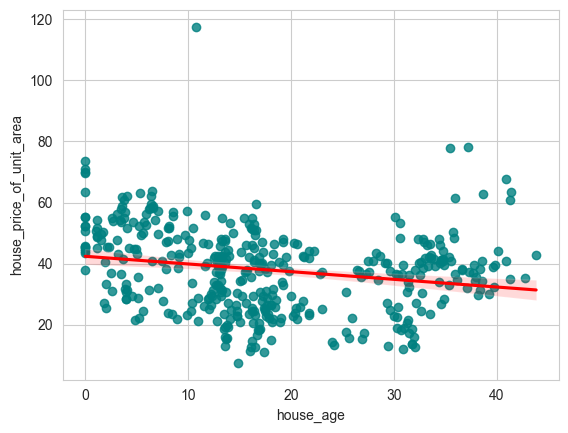

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(x=real_estate_data['house_age'], y=real_estate_data['house_price_of_unit_area'], scatter_kws={'color': 'teal'}, line_kws={'color': 'red'})
plt.show()

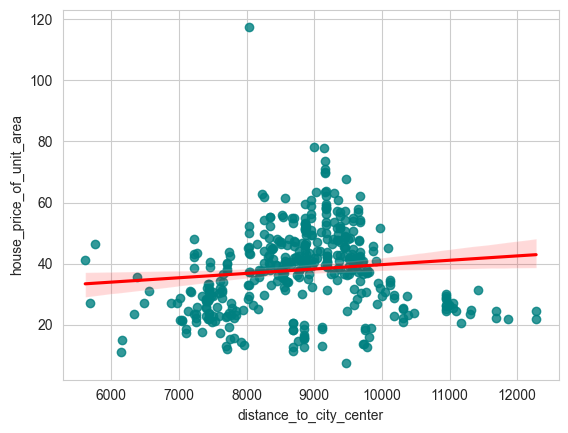

In [11]:
sns.regplot(x=real_estate_data['distance_to_city_center'], y=real_estate_data['house_price_of_unit_area'], scatter_kws={'color': 'teal'}, line_kws={'color': 'red'})
plt.show()

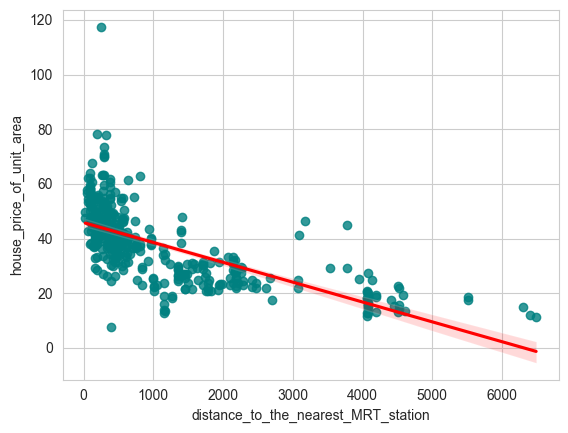

In [12]:
sns.regplot(x=real_estate_data['distance_to_the_nearest_MRT_station'], y=real_estate_data['house_price_of_unit_area'], scatter_kws={'color': 'teal'}, line_kws={'color': 'red'})
plt.show()

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline

# build the multivariate linear model with engineered features

preprocessing = ColumnTransformer(
    [
        ("cat", OneHotEncoder(drop='first', handle_unknown="ignore"), categorical_cols),
        ('quad', PolynomialFeatures(degree=2, include_bias=False), quad_cols)
    ], remainder='passthrough'
)

fe_multi_model = Pipeline(
        [("preprocess", preprocessing),
         ("regressor", LinearRegression())
         ], verbose=True
)

fe_multi_model.fit(X_train, y_train)

model_name = 'Linear Regression w. Engineered Features'

if model_name not in summary_df.Model.values:
    summary_df.loc[len(summary_df.index)] = [model_name, 
                                             '{:.4f}'.format(root_mean_squared_error(y_train, fe_multi_model.predict(X_train))),
                                             '{:.4f}'.format(root_mean_squared_error(y_test, fe_multi_model.predict(X_test)))]
summary_df

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s


,Model,Train RMSE,Holdout RMSE
0,Benchmark,12.3012,12.7846
1,Simple Linear Regression,8.4990,9.3673
2,Multivariate Linear Regression,6.8995,9.4153
3,Linear Regression w. Engineered Features,6.6811,7.8750


[Comment for fe model]

##### 2. Training more flexible models

###### LASSO

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

# alpha
alpha = np.linspace(0.1, 10.0, num=100)

# define cv search
lasso_search = GridSearchCV(
    ElasticNet(l1_ratio = 1, fit_intercept = True),
    {"alpha":alpha},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)
preprocessing = ColumnTransformer(
    [
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ], remainder='passthrough'
)

lasso_model = Pipeline(
        [("preprocess", preprocessing),
         ('interaction', PolynomialFeatures(degree=2, interaction_only=True,  include_bias=False)),
         ('scaling', StandardScaler()),
         ("regressor", lasso_search)
         ], verbose=True
)

lasso_model.fit(X_train, y_train)

model_name = 'LASSO'

if model_name not in summary_df.Model.values:
    summary_df.loc[len(summary_df.index)] = [model_name, 
                                             '{:.4f}'.format(root_mean_squared_error(y_train, lasso_model.predict(X_train))),
                                             '{:.4f}'.format(root_mean_squared_error(y_test, lasso_model.predict(X_test)))]
summary_df

[Pipeline] ........ (step 1 of 4) Processing preprocess, total=   0.0s
[Pipeline] ....... (step 2 of 4) Processing interaction, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing scaling, total=   0.0s
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ........................alpha=0.1;, score=-9.244 total time=   0.0s
[CV 2/5] END ........................alpha=0.1;, score=-7.647 total time=   0.0s
[CV 3/5] END .......................alpha=0.1;, score=-12.876 total time=   0.0s
[CV 4/5] END .......................alpha=0.1;, score=-12.562 total time=   0.0s
[CV 5/5] END .......................alpha=0.1;, score=-12.691 total time=   0.0s
[CV 1/5] END ........................alpha=0.2;, score=-8.692 total time=   0.0s
[CV 2/5] END ........................alpha=0.2;, score=-6.986 total time=   0.0s
[CV 3/5] END .......................alpha=0.2;, score=-12.107 total time=   0.0s
[CV 4/5] END .......................alpha=0.2;, score=-12.477 total time=   

,Model,Train RMSE,Holdout RMSE
0,Benchmark,12.3012,12.7846
1,Simple Linear Regression,8.4990,9.3673
2,Multivariate Linear Regression,6.8995,9.4153
3,Linear Regression w. Engineered Features,6.6811,7.8750
4,LASSO,7.4449,6.5936


In [15]:
lasso_search.best_params_

{'alpha': 1.0}

###### Random Forest

Would you launch your web app now? What options you might have to further improve the prediction performance?

Rerun three of your previous models (including both flexible and less flexible ones) on the full train set. Ensure that your test result remains comparable by keeping that dataset intact. (Hint: extend the code snippet below.) Did it improve the predictive power of your models? Where do you observe the biggest improvement? Would you launch your web app now?

real_estate_full = real_estate_data.loc[~real_estate_data.index.isin(X_test.index)]
print(f"Size of the full training set: {#TODO}")